# Imersão Dados - Alura

## Aula 4 - Modelo de _Machine Learning_

Após explorar o _DataSet_ e analisar as correlações entre as notas que compõem o exame, vamos montar um modelo para tentar determinar a nota de Matemática a partir das outras notas.

### Índice

- [Carregando os dados: montando os _DataSets_](#carregando-os-dados)
- [Separando os dados: treino e teste](#separando-os-dados)
- [Criando o modelo: regressão linear](#criando-o-modelo)
- [Avaliação qualitativa do modelo](#avaliação-qualitativa)
- [Avaliação quantitativa do modelo](#avaliação-quantitativa)
- [Reprodutibilidade e fatores de aleatoriedade](#reprodutibilidade)

### Carregando os dados

Então primeiro vamos montar um _DataFrame_ com o _input_ do nosso modelo (todas as notas exceto matemática) e outro com o que esperamos que seja nosso _output_ (apenas as notas de matemática).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dados = pd.read_csv('https://github.com/alura-cursos/imersao-dados-2-2020/blob/master/MICRODADOS_ENEM_2019_SAMPLE_43278.csv?raw=true')

len(dados)

127380

Como estamos carregando o _DataSet_ "original" com o objetivo de  criar um modelo capaz de predizer a nota de matemática a partir das outras notas do exame, devemos remover algumas linhas.

Primeiro vamos remover as linhas que possuem o valor `NaN` para alguma nota, pois não faz sentido usar candidatos que não fizeram alguma das provas. E também vamos remover os candidatos que zeraram a "nota total".

Perceba que diferente dos _notebooks_ anteriores que nos referimos ao _DataSet_ sem notas zero apenas por `dados_sem_nota_zero`, neste vamos usar apenas `dados`.

In [ ]:
# remove linhas com NaN em alguma nota
provas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']

dados = dados[provas].dropna()

len(dados)

92539

In [ ]:
# remove linhas com nota total igual a zero
dados = dados.query(f"({'+'.join(provas)}) != 0")

len(dados)

92537

In [ ]:
provas[:]
provas_entrada = provas[:]
provas_entrada.remove('NU_NOTA_MT')
provas_entrada

['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']

In [ ]:
# determina prova de saida a partir da intersecção das outras listas de provas
prova_saida = list(set(provas_entrada).symmetric_difference(provas))[0]
prova_saida

'NU_NOTA_MT'

Acima foram definidas as variáveis das provas de entrada e saída a partir de variáveis que já existiam, mas vamos fazer isso novamente, agora de uma forma mais clara e definir os _DataFrames_ de _input_ e _output_:

In [ ]:
provas_entrada = ['NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_REDACAO']
prova_saida = 'NU_NOTA_MT'

notas_entrada = dados[provas_entrada]
notas_saida = dados[prova_saida]

Quando modelos tem um _input_ e um _output_ bem definido para o modelo, é comum que essa relação seja representada como uma função matemática:

> **y** = f(**x**)

Nesse caso temos que as "notas de saída" são o **y**, variável dependente, e as notas de entrada o **x**, variável independente.

In [ ]:
y = notas_saida
x = notas_entrada

### Separando os dados

Mas antes de começar a criar o modelo de previsão da nota de matemática, vamos separar uma amostra dos dados para treinar esse modelo. A partir desse ponto vamos começar a usar módulos da biblioteca [`scikit-learn`](https://scikit-learn.org/stable/), que vai nos trazer várias facilidades para implementar nosso modelo. A primeira delas é justamente separar o _DataSet_ em dados para treinamento e teste.

Usando a função `train_test_split()` podemos definir o tamanho da amostra de teste e o "fator de aleatoriedade" usado para selecionar os dados, dessa forma garantimos a reprodutibilidade dessa etapa.

Essa função retorna uma lista e como sabemos seu tamanho podemos atribuir cada um dos seus elementos a um variável:

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 1234

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.25, random_state=SEED)

In [ ]:
print(len(x_treino))
len(x_treino) == len(y_treino)

69402


True

In [ ]:
print(len(x_teste))
len(x_teste) == len(y_teste)

23135


True

In [ ]:
len(x_treino) + len(x_teste) == len(dados)

True

### Criando o modelo

Agora vamos de fato começar a trabalhar no nosso "modelo de _machine learning_", que no caso vai usar um modelo de regressão linear para fitar os dados, o _Linear SVR_.

Vamos importar esse modelo do módulo `svm` do `scikit-learn` e instância-lo definindo um fator de aleatoriedade. Após isso damos um _fit_ nos nossos dados de treino:

In [ ]:
from sklearn.svm import LinearSVR

modelo = LinearSVR(random_state=SEED)
modelo.fit(x_treino, y_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=1234, tol=0.0001, verbose=0)

Agora que nosso modelo foi treinado, podemos mandá-lo predizer as notas de mátemática de acordo com as notas presentes no _DataSet_ de teste:

In [ ]:
predicao_modelo = modelo.predict(x_teste)
predicao_modelo

array([507.69957282, 429.89526224, 692.1774959 , ..., 554.0679202 ,
       538.09574975, 690.52994493])

### Avaliação qualitativa

Se compararmos as três primeiras notas mostradas acima com do _output_ esperado podemos ter uma noção superficial sobre o "quão bom" está nosso modelo.

Para uma representação visual podemos utilizar um gráfico de pontos, plotando o _output_ esperado em função da predição do modelo:

In [ ]:
y_teste[:3]

18355    626.9
43951    442.3
3805     634.1
Name: NU_NOTA_MT, dtype: float64

Text(0.5, 0, 'Predição do modelo')

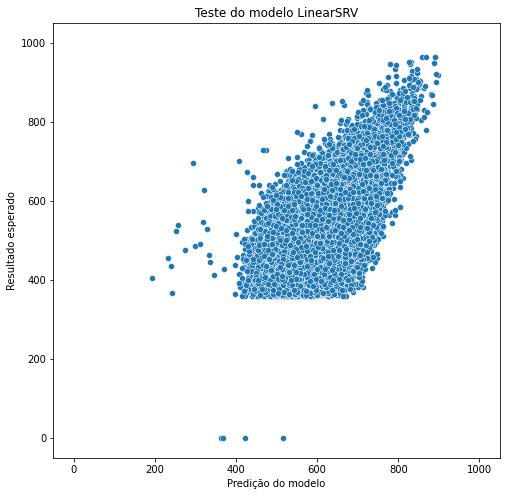

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=predicao_modelo, y=y_teste) # plot
plt.xlim((-50, 1050))
plt.ylim((-50, 1050))
plt.title('Teste do modelo LinearSRV')
plt.ylabel('Resultado esperado')
plt.xlabel('Predição do modelo')

Apenas para comparação, o gráfico de um modelo ideal deve ser uma reta a 45 graus e coeficiente linear zero:

Text(0.5, 0, 'Resultado esperado')

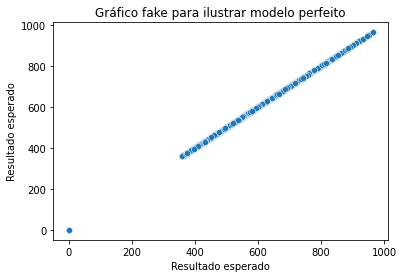

In [ ]:
sns.scatterplot(x=y_teste, y=y_teste) # plot
plt.title('Gráfico fake para ilustrar modelo perfeito')
plt.ylabel('Resultado esperado')
plt.xlabel('Resultado esperado')

Apenas verificando as notas zero esperadas:

In [ ]:
notas_zero_esperadas = y_teste[y_teste.isin([0])]
notas_zero_esperadas

28755    0.0
4923     0.0
28030    0.0
41918    0.0
Name: NU_NOTA_MT, dtype: float64

In [ ]:
x_teste.loc[notas_zero_esperadas.index]

,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_CN,NU_NOTA_REDACAO
28755,606.9,556.8,0.0,660.0
4923,0.0,418.5,373.4,320.0
28030,470.0,441.4,407.9,360.0
41918,474.4,528.4,0.0,560.0


Podemos plotar um gráfico do erro de cada nota em função da nota esperada:

Text(0.5, 0, 'Resultado esperado')

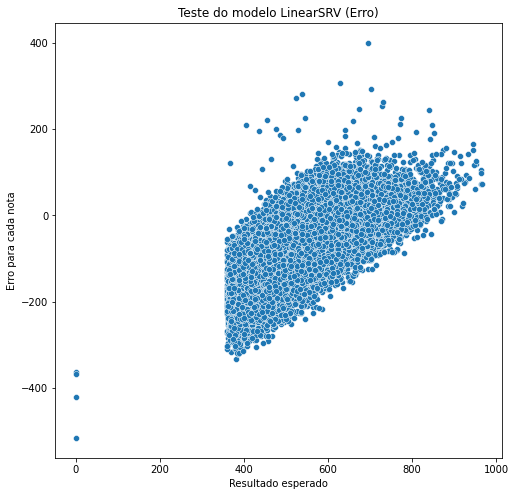

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_teste, y=y_teste - predicao_modelo) # plot
# plt.xlim((-50, 1050))
# plt.ylim((-50, 1050))
plt.title('Teste do modelo LinearSRV (Erro)')
plt.ylabel('Erro para cada nota')
plt.xlabel('Resultado esperado')

Uma coisa que podemos verificar através desse gráfico é que o erro não é uniforme. Se o erros fosse uniforme deveríamos ver uma distribuição dos pontos cuja melhor reta para se adequar a eles seria uma reta horizontal, mas a distribuição do erro que temos é linearmente dependente da nota esperada. Quanto mais baixa a nota esperada, maior é o erro para baixo, e quanto maior a nota esperada, maior o erro para cima.

Podemos plotar gráficos do resultado esperado em função de grandezas estátisticas como a moda e média, para ter uma idéia como nosso modelo baseado em regressão linear está performando:

Text(0.5, 0, 'Média das notas (CN, CH, MT, LC, REDACAO)')

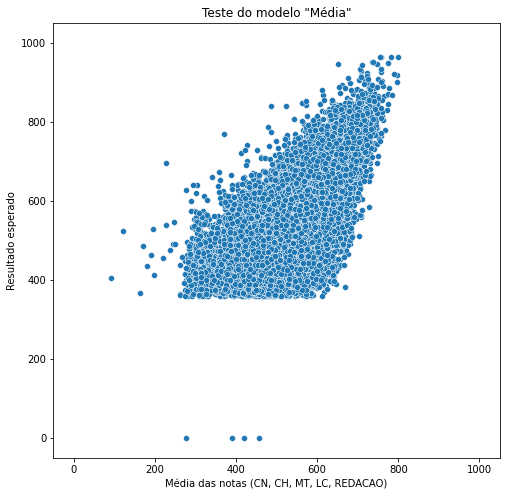

In [ ]:
# 1) modelo mais baseado apenas na média das notas usadas como input

plt.figure(figsize=(8,8))
sns.scatterplot(x=x_teste.mean(axis=1), y=y_teste) # plot
plt.xlim((-50, 1050))
plt.ylim((-50, 1050))
plt.title('Teste do modelo "Média"')
plt.ylabel('Resultado esperado')
plt.xlabel('Média das notas (CN, CH, MT, LC, REDACAO)')

Text(0.5, 0, 'Resultado esperado')

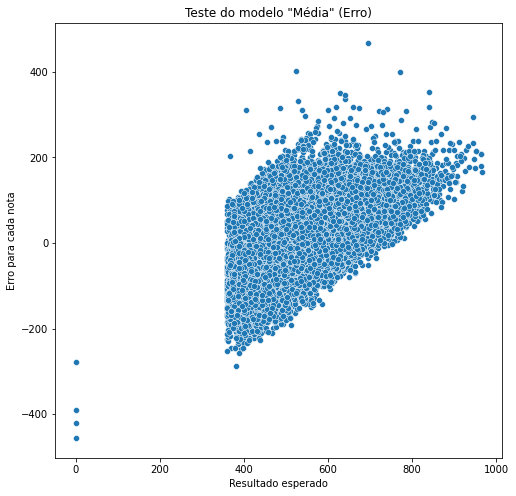

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_teste, y=y_teste - x_teste.mean(axis=1)) # plot
plt.title('Teste do modelo "Média" (Erro)')
plt.ylabel('Erro para cada nota')
plt.xlabel('Resultado esperado')

### Avaliação quantitativa

Agora vamos definir alguma métrica que permita avaliar o nosso modelo. Considerando que temos o valor esperado e o valor previsto, é natural pensar que essa métrica vai depender desses dois valores, mas talvez o cálculo mais adequado não seja apenas a subtração desses valores.

Vamos começar criando um _DataFrame_ com os valores que já utilizamos para montar os gráficos na etapa anterior:

In [ ]:
resultados = pd.DataFrame(data={
    'valor_esperado': y_teste,
    'predicao': predicao_modelo,
    'diff': y_teste - predicao_modelo
})
resultados

,valor_esperado,predicao,diff
18355,626.9,507.699573,119.200427
43951,442.3,429.895262,12.404738
3805,634.1,692.177496,-58.077496
86575,538.3,559.076269,-20.776269
67382,490.2,565.236779,-75.036779
...,...,...,...
118416,537.9,563.603296,-25.703296
59634,519.2,659.247099,-140.047099
43507,496.1,554.067920,-57.967920
48815,519.8,538.095750,-18.295750


Note que na coluna da diferença entre os valores temos números positivos e negativos, então se tirarmos a média dessa coluna teremos o erro atenuado e mascarado.

No momento ainda não temos informações suficientes para assumir qual tipo de erro contribui mais ou menos e como contribui, pois dependendo do contexto errar para cima ou para baixo pode ser pior ou melhor. Vamos então tornar a contribuição desses erros "iguais" elevando essa coluna ao quadrado:

In [ ]:
resultados['diff_qdd'] = resultados['diff']**2
resultados

,valor_esperado,predicao,diff,diff_qdd
18355,626.9,507.699573,119.200427,14208.741840
43951,442.3,429.895262,12.404738,153.877519
3805,634.1,692.177496,-58.077496,3372.995530
86575,538.3,559.076269,-20.776269,431.653348
67382,490.2,565.236779,-75.036779,5630.518191
...,...,...,...,...
118416,537.9,563.603296,-25.703296,660.659444
59634,519.2,659.247099,-140.047099,19613.189844
43507,496.1,554.067920,-57.967920,3360.279772
48815,519.8,538.095750,-18.295750,334.734459


Um valor que podemos usar como métrica para avaliar quão próximo da realidade o modelo está é a "raiz quadrada da média do erro ao quadrado", também conhecida como "erro quadrático médio". O ERQ vai nos dizer por quantos pontos em média nosso modelo está errando: 

In [ ]:
# ERQ
resultados['diff_qdd'].mean()

12839.950795942032

In [ ]:
# raiz do ERQ
resultados['diff_qdd'].mean()**(1/2)

113.31350667922175

Apenas esse valor não é suficiente para afirmar se nosso modelo é bom ou ruim. Uma forma de avaliar isso é comparando com o mesmo valor obtido através de outro modelo. O `scikit-learn` oferece um módulo `dummy` que nos ajuda com isso, permitindo criar um modelo _dummy_ para fins de comparação:

In [ ]:
from sklearn.dummy import DummyRegressor

modelo_dummy = DummyRegressor()
modelo_dummy.fit(x_treino, y_treino)
predicao_dummy = modelo_dummy.predict(x_teste)

In [ ]:
from sklearn.metrics import mean_squared_error

# raiz do ERQ
mean_squared_error(y_teste, predicao_dummy)**(1/2)

108.57583819223257

In [ ]:
# usar outro modelo de ML para treinar e comparar com o desenvolvido aqui
# olhar a doc do dummy e alterar a forma como é feita a regressão
# buscar outras métricas para avaliar modelos de regressão

### Reprodutibilidade

Perceba que o modelo _dummy_ genérico teve umERQ menor que o modelo baseado em _SVM_ (o que é isso exatamente, ainda não sei), então vamos apenas fazer alguns testes aqui, alterando alguns parâmetros.

Primeiro vamos treinar e rodar o modelo nas mesmas condições anteriores, definindo o fator de aleatoriedade já definido e usando o mesmo conjunto de dados para treino e teste:

In [ ]:
# treinando o modelo de regressão baseado em SVM com as mesmas condições anteriores
novo_modelo = LinearSVR(random_state=SEED)
novo_modelo.fit(x_treino, y_treino)
nova_predicao = novo_modelo.predict(x_teste)

# raiz do ERQ
mean_squared_error(y_teste, nova_predicao)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


12839.95079594202

Instânciando o modelo sem definir o fator de aleatoriedade:

In [ ]:
# treinando o modelo de regressão baseado em SVM sem definir um random_state, mas com os mesmos dados de treino e teste
novo_modelo = LinearSVR()
novo_modelo.fit(x_treino, y_treino)
nova_predicao = novo_modelo.predict(x_teste)

# raiz do ERQ
mean_squared_error(y_teste, nova_predicao)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


6084.73736604043

In [ ]:
# treinando o modelo de regressão baseado em SVM sem definir um random_state, mas com os mesmos dados de treino e teste
novo_modelo = LinearSVR()
novo_modelo.fit(x_treino, y_treino)
nova_predicao = novo_modelo.predict(x_teste)

# raiz do ERQ
mean_squared_error(y_teste, nova_predicao)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


18387.94487585218

Agora vamos separar novamente os dados para treino e teste, mas sem definir um fator de aleatoriedade nessa etapa. Após isso rodamos com o modelo instânciado das dusa formas acima:

In [ ]:
# separa os dados sem random state
novo_x_treino, novo_x_teste, novo_y_treino, novo_y_teste = train_test_split(x, y, test_size=0.25)

novo_x_treino.equals(x_treino)

False

In [ ]:
# instancia modelo com seed ja definida
antigo_modelo_com_novos_dados = LinearSVR(random_state=SEED)
antigo_modelo_com_novos_dados.fit(novo_x_treino, novo_y_treino)
nova_antiga_predicao_com_novos_dados = antigo_modelo_com_novos_dados.predict(novo_x_teste)

# raiz do ERQ
mean_squared_error(y_teste, nova_antiga_predicao_com_novos_dados)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


16907.896048466813

In [ ]:
# instancia modelo com seed ja definida
novo_modelo_com_novos_dados = LinearSVR()
novo_modelo_com_novos_dados.fit(novo_x_treino, novo_y_treino)
nova_predicao_com_novos_dados = novo_modelo_com_novos_dados.predict(novo_x_teste)

# raiz do ERQ
mean_squared_error(y_teste, nova_predicao_com_novos_dados)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


26981.422379046267

In [ ]:
# instancia modelo com seed ja definida
novo_modelo_com_novos_dados = LinearSVR()
novo_modelo_com_novos_dados.fit(novo_x_treino, novo_y_treino)
nova_predicao_com_novos_dados = novo_modelo_com_novos_dados.predict(novo_x_teste)

# raiz do ERQ
mean_squared_error(y_teste, nova_predicao_com_novos_dados)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


51377.265674810915

Perceba que no processo de separação dos dados já é possível introduizir fatores que contribuem para a aleatoriedade do resultado que podemos encontrar no modelo.